# Análise de Sentimento - Auto Atenção Completa

Nome: Matheus Gustavo Alves Sasso

Neste colab iremos melhorar o modelo anterior de análise de sentimento usando a Auto Atenção completa: embedding posicional, projeção linear do k,q,v e saída, Atenção multi-cabeça, Scaled Dot-product, Layer Normalization, Conexões residuais, Camada de feed forward (2-layer MLP).
Usaremos todo dataset do IMDB (25k treino, 25k teste).


In [20]:
import numpy as np 
import torch
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import torch.nn.functional as F
from numpy import genfromtxt
import torch.nn as nn
from torch.autograd import Variable



if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu" 
print(dev)
device = torch.device(dev)

cuda:0


# Preparando Dados

Primeiro, fazemos download do dataset:

In [21]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz

File ‘aclImdb.tgz’ already there; not retrieving.



## Carregando o dataset

In [22]:
import os


def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test = [True] * len(x_test_pos) + [False] * len(x_test_neg)



print(len(x_train), 'amostras de treino.')
print(len(x_test), 'amostras de teste.')

print('3 primeiras amostras treino:')
for x, y in zip(x_train[:3], y_train[:3]):
    print(y, x[:100])

print('3 últimas amostras treino:')
for x, y in zip(x_train[-3:], y_train[-3:]):
    print(y, x[:100])

print('3 primeiras amostras teste:')
for x, y in zip(x_test[:3], y_test[:3]):
    print(y, x[:100])

print('3 últimas amostras teste:')
for x, y in zip(x_test[-3:], y_test[-3:]):
    print(y, x[:100])

25000 amostras de treino.
25000 amostras de teste.
3 primeiras amostras treino:
True Following directly from where the story left off in part one, the second half which sets about telli
True This is a very, very early Bugs Bunny cartoon. As a result, the character is still in a transition p
True Unfortunately, SpaceCamp came out about the same time as the Challenger Explosion. Which really put 
3 últimas amostras treino:
False Dewaana as a film goes through the usual clichés. Man and Woman fall in love and marry, husband is s
False I am a relative latecomer to the transcendent work of film auteur Yasujiro Ozu, whose masterfully un
False I picked up this movie in the hope it would be similar to the hilarious "The Gamers" by Dead Gentlem
3 primeiras amostras teste:
True "Down Periscope" has been in our library since it first arrived in VHS. Since then, we have acquired
True A man named Jerry comes into possession of an ancient Aztec doll.However this creepy little figure i
True ...dislik

# Fazer download do word embedding

Primeiro fazemos download dos word embeddings. Lista dos modelos disponíveis: https://github.com/RaRe-Technologies/gensim-data#models

In [23]:
import gensim.downloader as api

word2vec_model = api.load("glove-wiki-gigaword-300")
print(word2vec_model.vectors.shape)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(400000, 300)


# Criando Vocabulário a partir do word embedding

In [24]:
import itertools

vocab = {word: index for index, word in enumerate(word2vec_model.index2word)}

# Adicionar pad token
vocab['[PAD]'] = len(vocab)
pad_vector = np.zeros((1, word2vec_model.vectors.shape[1]))
embeddings = np.concatenate((word2vec_model.vectors, pad_vector), axis=0)

print('Número de palavras no vocabulário:', len(vocab))
print(f'20 tokens mais frequentes: {list(itertools.islice(vocab.keys(), 20))}')
print(embeddings.shape)

Número de palavras no vocabulário: 400001
20 tokens mais frequentes: ['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']
(400001, 300)


# Tokenizando o dataset e convertendo para índices

In [25]:
import collections
import itertools


def tokenize(text):
    for char in ['"', '\'', '.', ',', ':', '-', '?', '!']:
        text = text.replace(char, ' ')
    return text.lower().split()


def tokens_to_ids(tokens, vocab):
    return [vocab[token] for token in tokens if token in vocab]


def tokens_to_ids_batch(texts, vocab):
    return [tokens_to_ids(tokenize(text), vocab) for text in texts]
        

x_train_indices = tokens_to_ids_batch(x_train, vocab)
x_test_indices = tokens_to_ids_batch(x_test, vocab)

print('Primeiro exemplo:')
print(x_train[0])
print(x_train_indices[0])
print(y_train[0])

Primeiro exemplo:
Following directly from where the story left off in part one, the second half which sets about telling the inevitable downfall and much more grim side of the man's legacy is exactly as such. In direct contrast to the first feature, part two represents a shift from Che the pride and glory of a revolutionised country, to Chestruggling liberator of a country to which he has no previous ties. The change of setting isn't just aesthetic; from the autumn and spring greys of the woodlands comes a change of tone and heart to the feature, replacing the optimism of the predecessor with a cynical, battered and bruised reality aligned to an all new struggle. Yet, as Che would go on to say himselfsuch a struggle is best told exactly as thata struggle. While Part One certainly helped document that initial surge to power that the revolutionary guerrilla acquired through just that, Part Two takes a much more refined, callous and bleak segment of Che's life and ambition, and gives i

# Preparação do arquivo CSV

## Transformando word ids em batches

In [26]:
def truncate_and_pad(batch_word_ids, pad_token_id, seq_length=64):

    # Truncate.
    batch_word_ids = [word_ids[:seq_length] for word_ids in batch_word_ids]

    # Create mask.
    mask = [[1] * len(word_ids) + [0] * (seq_length - len(word_ids)) for word_ids in  batch_word_ids]

    # Pad.
    batch_word_ids = [ word_ids + [pad_token_id] * (seq_length - len(word_ids)) for word_ids in batch_word_ids]

    return batch_word_ids, mask

texts = ['we like pizza', 'he does not like apples']
batch_word_ids = tokens_to_ids_batch(texts, vocab)
print(batch_word_ids)
batch, mask = truncate_and_pad(batch_word_ids=batch_word_ids,pad_token_id=vocab['[PAD]'],seq_length=8)

batch = np.array(batch)
mask = np.array(mask)
print('batch', batch)
print('mask', mask)
print('batch.shape:', batch.shape)
print('mask.shape:', mask.shape)

[[53, 117, 9388], [18, 260, 36, 117, 13134]]
batch [[    53    117   9388 400000 400000 400000 400000 400000]
 [    18    260     36    117  13134 400000 400000 400000]]
mask [[1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0]]
batch.shape: (2, 8)
mask.shape: (2, 8)


In [27]:
#transformando tudo para numpy
seq_length=128
X_train_batch, X_train_mask = truncate_and_pad(batch_word_ids=x_train_indices,pad_token_id=vocab['[PAD]'],seq_length=seq_length)
X_test_batch, X_test_mask = truncate_and_pad(batch_word_ids=x_test_indices,pad_token_id=vocab['[PAD]'],seq_length=seq_length)

#train
x_train_batch_np = np.array(X_train_batch)
x_train_mask_np = np.array(X_train_mask)
y_train_np = np.array(y_train)
#test
x_test_batch_np = np.array(X_test_batch)
x_test_mask_np = np.array(X_test_mask)
y_test_np = np.array(y_test)


print("------Treino------")
print(x_train_batch_np[5])
print(x_train_mask_np[5])
print(y_train_np[5])



------Treino------
[    49     64      0  35404     12   2290      0     33  31766     66
     53   1229    169      7   1005     12  11174     77  10212   4039
     63     32     77 123657   4039     34     41   1993     36   1085
     20   1534    555  11202      4    159     29   3462    929   1005
     63   1534     36    181     50    187     20   1534    120    751
    143   1085      5    642    999     19      0   9327  22553    326
   1177      5    456     37     14     36      7   1005      4   1716
    110     81   1765   4525   9388   1534     48    191    143    982
    639  19556      6     37   1005      5   4716     48    191   6829
   1784    542  60676   1377    120  66019   2159    159     29   2037
   7930     10     48    873     67   1534   4366  49534     41    346
     41    346     67   1534    120   1527    131      7  14700   1221
     34      0  12514    332   1666      4    346     71]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [0]:
# Salvando CSV
np.savetxt("x_train.csv", x_train_batch_np, delimiter=",")
np.savetxt("x_train_mask.csv", x_train_mask_np, delimiter=",")
np.savetxt("y_train.csv", y_train_np, delimiter=",")
np.savetxt("x_test.csv", x_test_batch_np, delimiter=",")
np.savetxt("x_test_mask.csv", x_test_mask_np, delimiter=",")
np.savetxt("y_test.csv", y_test_np, delimiter=",")


# Classe IMDB Dataset (Transformação dos dados em tensores pytorch)

In [0]:
class ImdbDataset(Dataset):
  def __init__(self, mode):
    super(ImdbDataset, self).__init__()
    if mode == 'train':
      self.path_x = 'x_train.csv'
      self.path_x_mask = 'x_train_mask.csv'
      self.path_y = 'y_train.csv'
    elif mode == 'test':
      self.path_x = 'x_test.csv'
      self.path_x_mask = 'x_test_mask.csv'
      self.path_y = 'y_test.csv'

    #recuperando do csv
    x = genfromtxt(self.path_x, delimiter=',')
    mask = genfromtxt(self.path_x_mask, delimiter=',')
    y = genfromtxt(self.path_y, delimiter=',')

    #trasformando em tensor
    self.x      = torch.from_numpy(x).type(torch.LongTensor)
    self.mask      = torch.from_numpy(mask).type(torch.LongTensor)
    self.y = torch.from_numpy(y).type(torch.LongTensor)

  def __len__(self):
    return self.x.shape[0]
  
  def __getitem__(self, index):
    return self.x[index],self.mask[index],self.y[index]

In [30]:
# testing class
torch_ds_train = ImdbDataset('train')
x0, mask0,y0 = torch_ds_train[0]
print(x0, mask0, y0)

tensor([  284,  1823,    25,   111,     0,   523,   218,   138,     6,   153,
           48,     0,   126,   343,    42,  2303,    59,  2821,     0,  7075,
        15062,     5,   181,    56,  8973,   437,     3,     0,   300,  1534,
         4267,    14,  2796,    19,   125,     6,  1494,  3313,     4,     0,
           58,  2047,   153,    55,  2748,     7,  3251,    25, 19227,     0,
         4926,     5,  7057,     3,     7, 90894,   123,     4, 38100,     3,
            7,   123,     4,    42,    18,    31,    84,   771,  1445,     0,
          511,     3,  1924, 75360,  2159,   120,    25,     0,  6588,     5,
         1509, 61685,     3,     0, 20417,   934,     7,   511,     3,  4445,
            5,  1058,     4,     0,  2047,  5043,     0,  5848,     3,     0,
         5286,    17,     7, 14734,  7201,     5, 14726,  2532, 11118,     4,
           29,    64,    50,  2651,   553,    19, 19227,    54,   242,    13,
            4,   203,     7,  2651,    14,   254,   154,  2796])

In [31]:
# testing DataLoader
torch_ds_train = ImdbDataset('train')
train_loader = DataLoader(torch_ds_train, 20, shuffle=False)
x_train, mask_train , y_train = next(iter(train_loader)) # 1 batch

torch_ds_test = ImdbDataset('test')
test_loader = DataLoader(torch_ds_test, 20, shuffle=True)
x_test, mask_test, y_test = next(iter(test_loader))  # 1 batch

print('Treino')
print(x_train)
print(mask_train) 
print(y_train)
print(f'input shape: {x_train.shape}') 
print(f'mask_train shape: {mask_train.shape}') 
print(f'label shape: {y_train.shape}')

print('\nTeste')
print(x_test)
print(mask_test) 
print(y_test)
print(f'input shape: {x_test.shape}')
print(f'mask_test shape: {mask_test.shape}')
print(f'label shape: {y_test.shape}')

Treino
tensor([[   284,   1823,     25,  ...,    254,    154,   2796],
        [    37,     14,      7,  ...,     56,    117,  39987],
        [  4716,    263,     66,  ...,     10,      0,   3570],
        ...,
        [  2017,  12269,   1534,  ..., 400000, 400000, 400000],
        [ 15917,    886,   1534,  ...,   1993,      7,    365],
        [    41,     58,  31993,  ..., 400000, 400000, 400000]])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
input shape: torch.Size([20, 128])
mask_train shape: torch.Size([20, 128])
label shape: torch.Size([20])

Teste
tensor([[    0,  4440,     6,  ...,     0,  2745,    14],
        [   41,    33,     4,  ...,    21,  1028,  1768],
        [  192,  2766,  2706,  ...,     0,   369,   120],
        ...,
        [

# Classes do Transformer com multihead Attention
Decidi dividir cada parte em uma classe para que eu pudesse entender melhor



## Definição dos tamanhos

In [32]:
torch_emb = torch.Tensor(embeddings) # V, D
vocab_size, D = torch_emb.shape
vocab_size, D

(400001, 300)

In [33]:
L = seq_length
print(L)

128


In [0]:
B = 20 

## Classe Atenção Matricial

$\text{Attention(Q,K,V) = }\text{softmax(}\dfrac{Q\cdot K^T}{\sqrt{{\text{D}}}}\text{)}V$.

In [0]:
import math
class AttentionMatrix(nn.Module):
  def forward(self,K,Q,V):
    D = K.shape[1]
    scores = torch.matmul(Q,K.transpose(-1,-2)) # N,L,L
    mask = torch.ones_like(scores)*(-1e10)
    score_com_mascara = torch.where(scores!=0,scores,mask)
    socre_normalizado = score_com_mascara/math.sqrt(D) #
    probs = F.softmax(socre_normalizado,dim=2)
    E = torch.matmul(probs, V)
    return E

In [36]:
emb = nn.Embedding.from_pretrained(torch_emb)
emb.requires_grad = False # V, D
att  = AttentionMatrix()
tensor_embedings = att(emb(x_train),emb(x_train),emb(x_train))
tensor_embedings.shape #B, L D

torch.Size([20, 128, 300])

## Postional Encoding



O Encondinds posicionais tem a mesma dimensão $D$ como os embeddings, assim os dois podem ser somados. Encodings posicionais podem ser aprendidos ou fixados.

Neste trabalho iremos testar encodings a partir de uma sequência de $0$ a $L$ que será a entrada para embeddings de dimensão $(L,D)$

<!-- In this work, we use sine and cosine functions of different frequencies:
where $pos$ is the position and $i$ is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of $P_{drop}=0.1$. -->

In [0]:
#Esta funcao é adaptada de: http://nlp.seas.harvard.edu/2018/04/03/attention.html 
class PositionalEncodingSenoidal(nn.Module):
    "Implement the PE function."
    def __init__(self, L,D, dropout=0.1):
        super(PositionalEncodingSenoidal, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(L, D)
        position = torch.arange(0, L).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, D, 2) * -(math.log(10000.0) / D))#curva de decaimento
        pe[:, 0::2] = torch.sin(position * div_term) #senos na metade de pe
        pe[:, 1::2] = torch.cos(position * div_term) #cosenos na outra metade de pe
        self.pe = pe.unsqueeze(0) # 1, L, D
        self.pe.to(device)

        
    def forward(self, C):
        # P = Variable(self.pe[:, :C.size(1)], requires_grad=False)
        P = self.pe
        P = P.to(device)
        # P.to(device)
        X = P + C
        return self.dropout(X)

In [0]:
class PositionalEncodingSimples(nn.Module):
    "Implement the PE function."
    def __init__(self, L, D):
        super(PositionalEncodingSimples, self).__init__()
        self.L = L
        self.pos_embedding  = nn.Embedding(L, D)
        
    def forward(self, C):# C=> D,L
        P = torch.arange(end=L, device=C.device) #D
        P = self.pos_embedding(P) #L, D
        #C.shape => B,L,D
        X = P + C #broadcasting de P em C na dimaensão N ===> P(L,D) e C(N,L,D)
        # X=> D,L
        return X

In [112]:
# # x_train.shape #=> B, L
# pos  = PositionalEncodingSimples(L=L,D=D)
# X = pos(torch.rand(B,L,D))

# x_train.shape #=> B, L
pos  = PositionalEncodingSenoidal(L=L,D=D)
X = pos(torch.rand(B,L,D))

cuda:0


## Classe Multihead Attention

In [0]:
class MultiHeadedAttention(nn.Module):
    def __init__(self,L,D,H):
      "Take in model size and number of heads."
      super(MultiHeadedAttention, self).__init__()
   

      self.d_k = D//H
      
      self.H = H
      self.L = L
      self.D = D
      
      #classe de atenção
      self.attention =  AttentionMatrix()

      #projeções lineares
      self.Wq = nn.Linear(self.D, self.D, bias=False)
      self.Wk = nn.Linear(self.D, self.D, bias=False)
      self.Wv = nn.Linear(self.D, self.D, bias=False)
      self.Wo = nn.Linear(self.D, self.D, bias=False)

        
    def forward(self,x,mask=None):
 
      # self.Wq(x).shape = self.Wk(x).shape = self.Wv(x).shape => N,L,D 

      q = self.Wq(x).view(-1, self.L, self.H,  self.d_k) # N, L, H , D/H
      k = self.Wk(x).view(-1, self.L, self.H,  self.d_k) # N, L, H , D/H
      v = self.Wv(x).view(-1, self.L, self.H,  self.d_k) # N, L, H , D/H

      # Transpor para: N, H, L, D/H
      q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

      new_x = self.attention(q, k, v)    # new_x.shape = N, H, L, D/H
      new_x = new_x.transpose(-3, -2).contiguous()  # new_x.shape = N, L, H, D/H
      new_x = new_x.view(-1, L, D) #N, L, D => Surepessão de H nas multiplicações matriciais

      return self.Wo(new_x)

In [40]:
multi_head_attention  = MultiHeadedAttention(L=L,D=D,H=1)
emb = nn.Embedding.from_pretrained(torch_emb)
emb.requires_grad = False #V,D
Wo = multi_head_attention(emb(x_train))
Wo.shape


torch.Size([20, 128, 300])

## Classe Transformer Encoder

![https://C:\Users\Matheus\Desktop\desenho_rede](https://C:\Users\Matheus\Desktop\desenho_rede)


In [0]:
# https://pytorch.org/docs/stable/_modules/torch/nn/modules/activation.html#MultiheadAttention
class TransformerEncoder(nn.Module):
  def __init__(self,H,L,hidden_dim,embeddings=torch_emb, pos_emb = 'senoidal'):#H = nheads
      super(TransformerEncoder, self).__init__()

      #Num max palavras sentença
      self.L = L

      #numero de cabeças
      self.H  = H

      #embeddings
      self.weight = embeddings #pesos fixos pré treinados
      self.D =  self.weight.shape[1] 
      self.emb = nn.Embedding.from_pretrained(self.weight)
      self.emb.requires_grad = False 

      #classe positional embedding
      if pos_emb == 'simples':
         self.positional_embedding =  PositionalEncodingSimples(L=self.L, D=self.D)
      elif pos_emb == 'senoidal':
        self.positional_embedding =  PositionalEncodingSenoidal(L=self.L, D=self.D)

      #classe de atenção multi head
      self.multi_head_attention = MultiHeadedAttention(self.L,self.D,self.H)

      #layers para add & norm
      self.layer_norm_1 = nn.LayerNorm(D)
      self.layer_norm_2 = nn.LayerNorm(D)

      #rede feedforward
      self.feedforward = nn.Sequential(
        nn.Linear(self.D,self.D),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(self.D,self.D)
       )

      #Englobamento da rede
      self.net = nn.Sequential(
       nn.Linear(self.D,hidden_dim),
       nn.ReLU(),
       nn.Dropout(0.1),
       nn.Linear(hidden_dim,2)
      )

  def forward(self, x, mask):
    
    #Not Postitional Embedding
    C_emb = self.emb(x) # B,L,D
    
    #Postitional Embedding
    X_emb = r1 =  self.positional_embedding(C_emb) # B,L,D

    #Multihead_Attention
    E =  self.multi_head_attention(X_emb) # B,L,D

    # Add & Norm
    E = r2 = self.layer_norm_1(E + r1)# B,L,D

    #feed forward
    ff = self.feedforward(E)# B,L,D

    # Add & Norm
    # ff = self.residual_layer(ff)# B,L,D
    ff = self.layer_norm_2(ff + r2)# B,L,D

    # Embeddings Mean
    ff_sum = torch.sum(ff, dim=1)#D,B
    mask = torch.sum(mask, dim=1)# Antes: B,L ; Depois:B
    ff_sum_transposto = torch.t(ff_sum)#D,B
    ff_mean = torch.div(ff_sum_transposto, mask)#D,B
    ff_mean_transposto = torch.t(ff_mean)#B,D

    #logits
    logits = self.net(ff_mean_transposto)
    return logits

# Overfit One Batch

In [0]:
def train_one_batch(model, batch, criterion, optimizer):
  model.train() #modo de treino
  inputs, mask, target = batch[0].to(device), batch[1].to(device),  batch[2].to(device)
  loss_batch_vector = []
  correct = 0 
  total = 0
  optimizer.zero_grad()
  y_logits = model(inputs,mask)
  #loss
  loss = criterion(y_logits, target)#criterion is the loss function
  loss_batch_vector.append(loss.item())
  loss.backward()
  optimizer.step()
  loss_mean = sum(loss_batch_vector)/len(loss_batch_vector)
  return loss_mean

In [0]:
def test_one_batch(model, batch):
  model.eval()#modo de avaliação
  correct = 0 
  total = 0
  loss_batch_vector = []
  inputs, mask, target = batch[0].to(device), batch[1].to(device),  batch[2].to(device)
  y_logits = model(inputs,mask)
  #acc
  _, predicted = torch.max(y_logits.data, 1)
  total += target.size(0)
  correct += (predicted == target).sum().item()
  acc_mean = (100 * correct / total)
  return acc_mean

In [158]:
N_EPOCHS = 200
BS = 50
train_loader = DataLoader(torch_ds_train, BS, shuffle=True)
test_loader = DataLoader(torch_ds_test, BS, shuffle=False)
LR =0.001
N_EPOCHS = 10
model = TransformerEncoder(H = 6,L=L,embeddings=torch_emb,hidden_dim=64)
model.to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR) #mesmo do artigo

one_batch_train = next(iter(train_loader))
one_batch_test = next(iter(test_loader))

trials = {}
results = {}
train_loss_list = []
test_acc_list = []
id_best_iteration = 0
best_acc = 0

for EP in range(N_EPOCHS):

  train_loss =  train_one_batch(model, one_batch_train, criterion, optimizer)
  test_acc =  test_one_batch(model, one_batch_test)
  
  train_loss_list.append(train_loss)
  test_acc_list.append(test_acc)

  best_acc = best_acc if (best_acc>test_acc) else test_acc
  
  print('Train_LOSS: ',train_loss,'Test_ACC: ',test_acc,'Best_ACC: ',best_acc)

Train_LOSS:  0.7164361476898193 Test_ACC:  0.0 Best_ACC:  0.0
Train_LOSS:  0.8158985376358032 Test_ACC:  0.0 Best_ACC:  0.0
Train_LOSS:  0.6907705664634705 Test_ACC:  100.0 Best_ACC:  100.0
Train_LOSS:  0.7055114507675171 Test_ACC:  100.0 Best_ACC:  100.0
Train_LOSS:  0.695076048374176 Test_ACC:  0.0 Best_ACC:  100.0
Train_LOSS:  0.6923561096191406 Test_ACC:  0.0 Best_ACC:  100.0
Train_LOSS:  0.6984097361564636 Test_ACC:  0.0 Best_ACC:  100.0
Train_LOSS:  0.6856863498687744 Test_ACC:  0.0 Best_ACC:  100.0
Train_LOSS:  0.6832669973373413 Test_ACC:  0.0 Best_ACC:  100.0
Train_LOSS:  0.686720073223114 Test_ACC:  0.0 Best_ACC:  100.0


# Experimentação


## Funções de treino e teste

In [0]:
def train(model, train_loader, criterion, optimizer):
  model.train() #modo de treino
  loss_batch_vector = []
  correct = 0 
  total = 0
  for inputs, mask, target in train_loader:
    inputs, mask, target = inputs.to(device), mask.to(device),  target.to(device)

    optimizer.zero_grad()
    y_logits = model(inputs,mask)
    #loss
    loss = criterion(y_logits, target)#criterion is the loss function
    loss_batch_vector.append(loss.item())
    loss.backward()
    optimizer.step()

  loss_mean = sum(loss_batch_vector)/len(loss_batch_vector)
  return loss_mean
  
def test(model, test_loader, criterion, optimizer):
  model.eval()#modo de avaliação
  correct = 0 
  total = 0
  loss_batch_vector = []
  with torch.no_grad():
    for inputs, mask, target in test_loader:
      inputs, mask, target = inputs.to(device), mask.to(device),  target.to(device)
      y_logits = model(inputs,mask)
      #acc
      _, predicted = torch.max(y_logits.data, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()
  acc_mean = (100 * correct / total)
  return acc_mean

## Função de Avaliação

In [0]:
import time
def evaluate(model,optimizer,criterion,torch_ds_train,torch_ds_test,BS,N_EPOCHS):

  trials = {}
  results = {}
  train_loss_list = []
  test_acc_list = []
  id_best_iteration = 0
  best_acc = 0
  train_time = 0
  test_time = 0

  for EP in range(N_EPOCHS):

    train_loader = DataLoader(torch_ds_train, BS, shuffle=True)
    test_loader = DataLoader(torch_ds_test, BS, shuffle=False)

    start_time = time.time()
    train_loss =  train(model, train_loader, criterion, optimizer)
    end_time_train = time.time() - start_time

    start_time = time.time()
    test_acc =  test(model, test_loader, criterion, optimizer)
    end_time_test = time.time() - start_time


    train_time+=end_time_train
    test_time+=end_time_test
    # Condição para parar de rodar pq ja atingiu o melhor
    if test_acc > best_acc:
      count=0
    else:
      count+=1
    
    if count >= 10 :
      break
    #####################################################

    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)

    best_acc = best_acc if (best_acc>test_acc) else test_acc

  
  return train_loss_list, test_acc_list,best_acc,train_time/N_EPOCHS,test_time/N_EPOCHS

## Função Visualização

In [0]:
def visualization(N_EPOCHS,train_loss_list,test_acc_list):

  x = range(N_EPOCHS)

  # Loss plot
  plt.subplot(1, 2, 1)
  plt.xlabel("Epoch")
  plt.ylabel("Train Loss")
  plt.plot(x, train_loss_list, '-')
  plt.legend()

  # Accuracy plot
  plt.subplot(1, 2, 2)
  plt.xlabel("Epoch")
  plt.ylabel("Test Accuracy")
  plt.plot(x, test_acc_list, '-')
  plt.legend()

  plt.tight_layout()
  plt.show()

## **Avaliação**

In [0]:
torch_ds_train = ImdbDataset('train')
torch_ds_test = ImdbDataset('test')

**Otimizador Adam + Positional Embedding Senoidal**

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Best Accuracy:  82.66
Number of nodes:  561194
Tempo de treino:  5.916898741722107
Tempo de teste:  1.8148706436157227
Otimizador Adam + Positional Embedding Senoidal


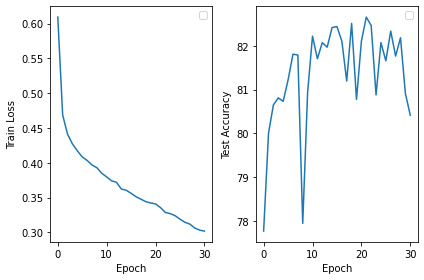

In [147]:
model = TransformerEncoder(H = 6,L=L,embeddings=torch_emb,hidden_dim=64)
model = model.to(device)

# n_nodes = sum([torch.tensor(x.size()).prod() for x in model.parameters()])
#Parametros que variam
LR =0.0001
BS=20
N_EPOCHS = 50
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR) #mesmo do artigo
#Adamax is supposed to be used over Adam when you’re using some setup that has sparse parameter updates (ie word embeddings).
train_loss_list, test_acc_list,best_acc,train_time,test_time = evaluate(model,optimizer,criterion,torch_ds_train,torch_ds_test,BS,N_EPOCHS)

print('Best Accuracy: ',best_acc)
n_nodes = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of nodes: ', n_nodes)
print('Tempo de treino: ',train_time)
print('Tempo de teste: ',test_time)
print('Otimizador Adam + Positional Embedding Senoidal')
visualization(len(train_loss_list),train_loss_list,test_acc_list)

**Otimizador Adamax + Positional Embedding Senoidal**

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Best Accuracy:  82.744
Number of nodes:  561194
Tempo de treino:  9.825117573738098
Tempo de teste:  2.5649031019210815
Otimizador Adamax + Positional Embedding Senoidal


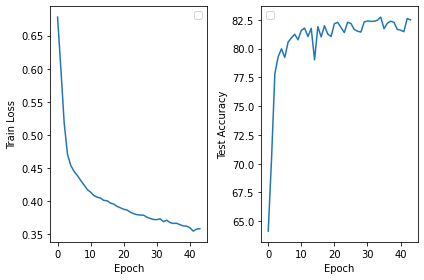

In [148]:
model = TransformerEncoder(H = 6,L=L,embeddings=torch_emb,hidden_dim=64)
model = model.to(device)

# n_nodes = sum([torch.tensor(x.size()).prod() for x in model.parameters()])
#Parametros que variam
LR =0.0001
BS=20
N_EPOCHS = 50
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adamax(model.parameters(), lr=LR) #mesmo do artigo
#Adamax is supposed to be used over Adam when you’re using some setup that has sparse parameter updates (ie word embeddings).
train_loss_list, test_acc_list,best_acc,train_time,test_time = evaluate(model,optimizer,criterion,torch_ds_train,torch_ds_test,BS,N_EPOCHS)

print('Best Accuracy: ',best_acc)
n_nodes = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of nodes: ', n_nodes)
print('Tempo de treino: ',train_time)
print('Tempo de teste: ',test_time)
print('Otimizador Adamax + Positional Embedding Senoidal')
visualization(len(train_loss_list),train_loss_list,test_acc_list)

**Otimizador Nesterov + Positional Embedding Senoidal**



No handles with labels found to put in legend.
No handles with labels found to put in legend.


Best Accuracy:  77.892
Number of nodes:  561194
Tempo de treino:  6.932837648391724
Tempo de teste:  2.6634332656860353
Otimizador Nesterov + Positional Embedding Senoidal


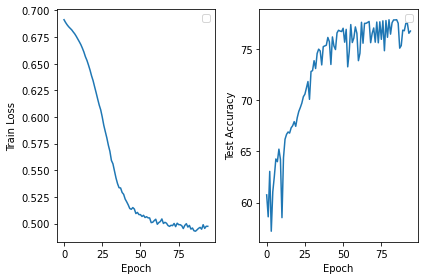

In [159]:
model = TransformerEncoder(H = 6,L=L,embeddings=torch_emb,hidden_dim=64)
model = model.to(device)

# n_nodes = sum([torch.tensor(x.size()).prod() for x in model.parameters()])
#Parametros que variam
LR =0.0001
BS=20
N_EPOCHS = 100
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, nesterov=True, momentum=0.9,weight_decay=0.01) #mesmo do artigo
#Adamax is supposed to be used over Adam when you’re using some setup that has sparse parameter updates (ie word embeddings).
train_loss_list, test_acc_list,best_acc,train_time,test_time = evaluate(model,optimizer,criterion,torch_ds_train,torch_ds_test,BS,N_EPOCHS)

print('Best Accuracy: ',best_acc)
n_nodes = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of nodes: ', n_nodes)
print('Tempo de treino: ',train_time)
print('Tempo de teste: ',test_time)
print('Otimizador Nesterov + Positional Embedding Senoidal')
visualization(len(train_loss_list),train_loss_list,test_acc_list)

**Otimizador Adam + Positional Embedding Sequencial**

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Best Accuracy:  80.1
Number of nodes:  599594
Tempo de treino:  3.757181282043457
Tempo de teste:  1.0730781507492066
Otimizador Adam + Positional Embedding Sequencial


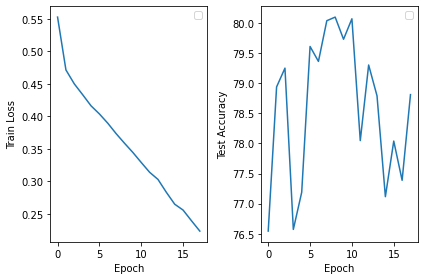

In [153]:
model = TransformerEncoder(H = 6,L=L,embeddings=torch_emb,hidden_dim=64,pos_emb = 'simples')
model = model.to(device)

# n_nodes = sum([torch.tensor(x.size()).prod() for x in model.parameters()])
#Parametros que variam
LR =0.0001
BS=20
N_EPOCHS = 50
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR) #mesmo do artigo
#Adamax is supposed to be used over Adam when you’re using some setup that has sparse parameter updates (ie word embeddings).
train_loss_list, test_acc_list,best_acc,train_time,test_time = evaluate(model,optimizer,criterion,torch_ds_train,torch_ds_test,BS,N_EPOCHS)

print('Best Accuracy: ',best_acc)
n_nodes = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of nodes: ', n_nodes)
print('Tempo de treino: ',train_time)
print('Tempo de teste: ',test_time)
print('Otimizador Adam + Positional Embedding Sequencial')
visualization(len(train_loss_list),train_loss_list,test_acc_list)

**Otimizador Adamax + Positional Embedding Sequencial**

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Best Accuracy:  79.532
Number of nodes:  599594
Tempo de treino:  5.07312159538269
Tempo de teste:  1.2409497928619384
Otimizador Adamax + Positional Embedding Sequencial


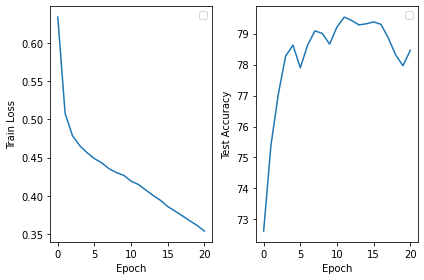

In [154]:
model = TransformerEncoder(H = 6,L=L,embeddings=torch_emb,hidden_dim=64,pos_emb = 'simples')
model = model.to(device)

# n_nodes = sum([torch.tensor(x.size()).prod() for x in model.parameters()])
#Parametros que variam
LR =0.0001
BS=20
N_EPOCHS = 50
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adamax(model.parameters(), lr=LR) #mesmo do artigo
#Adamax is supposed to be used over Adam when you’re using some setup that has sparse parameter updates (ie word embeddings).
train_loss_list, test_acc_list,best_acc,train_time,test_time = evaluate(model,optimizer,criterion,torch_ds_train,torch_ds_test,BS,N_EPOCHS)

print('Best Accuracy: ',best_acc)
n_nodes = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of nodes: ', n_nodes)
print('Tempo de treino: ',train_time)
print('Tempo de teste: ',test_time)
print('Otimizador Adamax + Positional Embedding Sequencial')
visualization(len(train_loss_list),train_loss_list,test_acc_list)

**Otimizador Nesterov + Positional Embedding Sequencial**

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Best Accuracy:  75.068
Number of nodes:  599594
Tempo de treino:  7.710545253753662
Tempo de teste:  2.7871691608428955
Otimizador Nesterov + Positional Embedding Sequencial


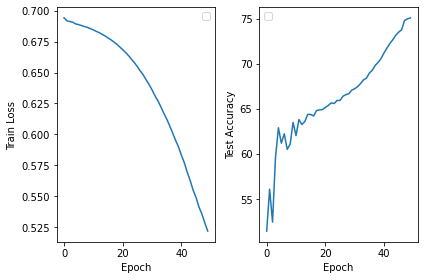

In [155]:
model = TransformerEncoder(H = 6,L=L,embeddings=torch_emb,hidden_dim=64,pos_emb = 'simples')
model = model.to(device)

# n_nodes = sum([torch.tensor(x.size()).prod() for x in model.parameters()])
#Parametros que variam
LR =0.0001
BS=20
N_EPOCHS = 100
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, nesterov=True, momentum=0.9,weight_decay=0.01) #mesmo do artigo
#Adamax is supposed to be used over Adam when you’re using some setup that has sparse parameter updates (ie word embeddings).
train_loss_list, test_acc_list,best_acc,train_time,test_time = evaluate(model,optimizer,criterion,torch_ds_train,torch_ds_test,BS,N_EPOCHS)

print('Best Accuracy: ',best_acc)
n_nodes = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of nodes: ', n_nodes)
print('Tempo de treino: ',train_time)
print('Tempo de teste: ',test_time)
print('Otimizador Nesterov + Positional Embedding Sequencial')
visualization(len(train_loss_list),train_loss_list,test_acc_list)

# Tunando Hyperparâmetros Manualmente (Acabei não usando, não melhorou muito o resultado)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


EPOCHS: 50 BS: 25 OPT: Adam POS_EMB: senoidal LR:0.0001 HIDDEN_DIM: 32 HEADS: 6, NUMBER_NODES: 551498


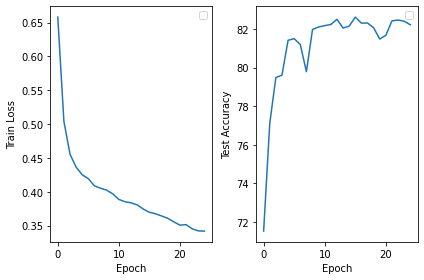

No handles with labels found to put in legend.
No handles with labels found to put in legend.


EPOCHS: 50 BS: 25 OPT: Adam POS_EMB: senoidal LR:0.0005 HIDDEN_DIM: 32 HEADS: 6, NUMBER_NODES: 551498


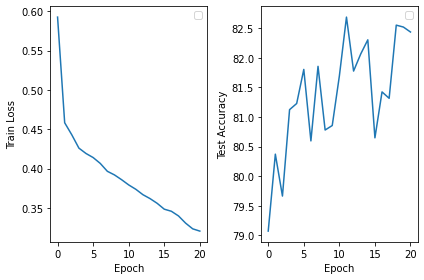

No handles with labels found to put in legend.
No handles with labels found to put in legend.


EPOCHS: 50 BS: 25 OPT: Adam POS_EMB: senoidal LR:0.001 HIDDEN_DIM: 32 HEADS: 6, NUMBER_NODES: 551498


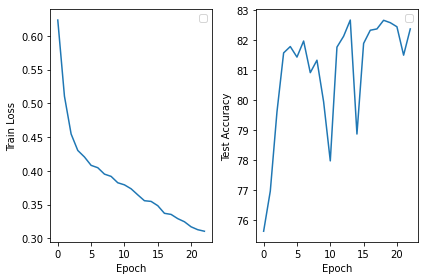

No handles with labels found to put in legend.
No handles with labels found to put in legend.


EPOCHS: 50 BS: 25 OPT: Adam POS_EMB: senoidal LR:0.005 HIDDEN_DIM: 32 HEADS: 6, NUMBER_NODES: 551498


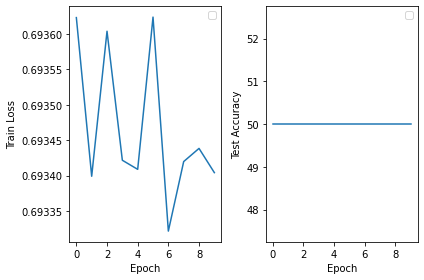

No handles with labels found to put in legend.
No handles with labels found to put in legend.


EPOCHS: 50 BS: 25 OPT: Adam POS_EMB: senoidal LR:0.01 HIDDEN_DIM: 32 HEADS: 6, NUMBER_NODES: 551498


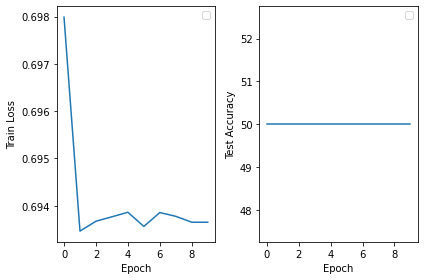

No handles with labels found to put in legend.
No handles with labels found to put in legend.


EPOCHS: 50 BS: 50 OPT: Adam POS_EMB: senoidal LR:0.0001 HIDDEN_DIM: 32 HEADS: 6, NUMBER_NODES: 551498


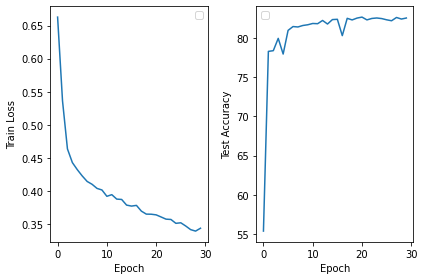

KeyboardInterrupt: ignored

In [139]:

#Peguei a idei deste bloco do Diedre, porque não consegui fazer com GreedSearch
#Variáveis
LEARNING_RATES = [0.0001,0.0005,0.001, 0.005, 0.01]
HIDDEN_DIM =  [32,64,128]
H_size = [6]
Batch_Sizes = [25,50,75]
OPTINM = ['Adam','Adamax','Nesterov']
POS_EMBS = ['senoidal','simples'] 

#Fixos
torch_ds_train = ImdbDataset('train')
torch_ds_test = ImdbDataset('test')
criterion = torch.nn.CrossEntropyLoss().to(device)
N_EPOCHS = 50
best_global_acc = 0
best_model = ""


for pe in POS_EMBS:
  for optim in OPTINM:
    for nheads in H_size:
      for hd in HIDDEN_DIM: 
        for bs in Batch_Sizes:
          for lr in LEARNING_RATES:
            

            #modelo
            model = TransformerEncoder(H = nheads,L=L,embeddings=torch_emb,hidden_dim=hd,pos_emb = pe)
            model = model.to(device)

            # Otimizador
            if optim == 'Adam':
              optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            elif optim == 'Adamax':
              optimizer = torch.optim.Adamax(model.parameters(), lr=lr)
            elif optim == 'Nesterov':
              optimizer = torch.optim.SGD(model.parameters(), lr=lr, nesterov=True)

            #numero de nós
            n_nodes = sum(p.numel() for p in model.parameters() if p.requires_grad)
            
            #avaliando
            train_loss_list, test_acc_list,best_acc = evaluate(model,optimizer,criterion,torch_ds_train,torch_ds_test,bs,N_EPOCHS)
                                                      

            description = f"EPOCHS: {N_EPOCHS} BS: {bs} OPT: {optim} POS_EMB: {pe} LR:{lr} HIDDEN_DIM: {hd} HEADS: {nheads}, NUMBER_NODES: {n_nodes}"
            len_til_best = len(train_loss_list)
            print(description)
            visualization(len_til_best,train_loss_list,test_acc_list)
            
            if best_acc> best_global_acc:
              best_model = description

# Save best ACC and parameters in a txt file
with open(os.path.join("results", best_model + " BEST_ACC:" + str(best_global_acc) + ".txt"), 'a') as result_file:
    result_file.write(str(best_acc))



# Tunando Hyperparâmetros com Skorch (Inativo porque como no forward tem X e mask ta dando erro e aparentemente não tem essa condição pré implementada no greed search)

Essa solução tinha visto num lab Anterior do Rafael

In [0]:
! pip install skorch
import skorch

     |████████████████████████████████| 122kB 23.8MB/s 


In [0]:
from skorch.callbacks import EarlyStopping, Checkpoint, ProgressBar, EpochTimer
from skorch.dataset import CVSplit
# checkpoint = Checkpoint(dirname='exp/', monitor="valid_loss_best") 
early_stopping = skorch.callbacks.EarlyStopping(patience=10)

model_Adam = skorch.NeuralNetClassifier(
            TransformerEncoder,
            max_epochs=300,
            batch_size=50,
            criterion=torch.nn.CrossEntropyLoss,
            module__H= 6,
            module__embeddings=torch_emb,
            module__L = 128,
            module__hidden_dim = 128,
            # train_split = None,
            optimizer = torch.optim.Adam,
            optimizer__lr = 0.003,
            device=device,
            # iterator_train__shuffle = True,
            # iterator_train__pin_memory= True,
            # iterator_valid__pin_memory= True,
            
            
            iterator_train__shuffle=True,
            train_split=CVSplit(cv=3, stratified=True),
            callbacks=[early_stopping]
)

In [0]:
model_Adam.fit(train_data, y=Y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5991       0.7449        0.5130  7.7911
      2        0.5040       0.7906        0.4648  7.7156
      3        0.4714       0.7916        0.4505  7.7141
      4        0.4644       0.7978        0.4391  7.7194


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=TransformerEncoder(
    (emb): Embedding(400001, 300)
    (positional_embedding): PositionalEncodingSimples(
      (pos_embedding): Embedding(128, 300)
    )
    (multi_head_attention): MultiHeadedAttention(
      (attention): AttentionMatrix()
      (Wq): Linear(in_features=300, out_features=300, bias=False)
      (Wk): Linear(in_features=300, out_features=300, bias=False)
      (Wv): Linear(in_features=300, out_features=300, bias=False)
      (Wo): Linear(in_features=300, out_features=300, bias=False)
    )
    (layer_norm_1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (layer_norm_2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (feedforward): Sequential(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=300, out_features=300, bias=True)
    )
    (net): Sequential(
      (0): Linear(

In [0]:
from sklearn.model_selection import GridSearchCV
params = {
    'optimizer__lr': [0.0001,0.0005,0.001, 0.005, 0.01, 0.05, 0.1],
    'module__hidden_dim': [32,64,128, 256],
    'module__H': [4,6,8],
    # 'batch_size': [20,50,100]
}
gs = GridSearchCV(model_Adam, params, refit=True, cv=3, scoring='accuracy', n_jobs=1, verbose=1)

In [0]:
x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg
y_train = [1] * len(x_train_pos) + [0] * len(x_train_neg)
y_test = [1] * len(x_test_pos) + [0] * len(x_test_neg)
L=128
X_train_target, X_train_mask = truncate_and_pad(batch_word_ids=x_train_indices,pad_token_id=vocab['[PAD]'],seq_length=L)
# X_test_target, X_test_mask = truncate_and_pad(batch_word_ids=x_test_indices,pad_token_id=vocab['[PAD]'],seq_length=L)

X_train = torch.Tensor(X_train_target).type(torch.long)
X_mask = torch.Tensor(X_train_mask).type(torch.long)
Y_train = torch.Tensor(y_train).type(torch.long)
# Y_test = torch.Tensor(y_test).type(torch.long)
train_data = {"x": X_train, "mask": X_mask}
train_data = [X_train,X_mask]

In [0]:
gs.fit(train_data, y=Y_train)

ValueError: ignored

In [0]:
print(gs.best_score_, gs.best_params_)

In [0]:
epochs = [i for i, _ in enumerate(gs.best_estimator_.history)]
train_loss = gs.best_estimator_.history[:, 'train_loss']
valid_loss = gs.best_estimator_.history[:, 'valid_loss']
accuracy = gs.best_estimator_.history[:, 'valid_acc']

In [0]:
plt.plot(epochs, train_loss)
plt.plot(epochs, valid_loss)
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('XEntropy')
plt.legend(['train', 'validation'])
plt.show()

In [0]:
plt.plot(epochs, accuracy)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.show()

# Aprendizados

 

*   Pela maneira em que eu organizei meu código não deu para considerar o tamanho da sequência $L$ na tunagem de hyper-parâmetros, logo é possível pra melhorar.

* Li no Reddit que o Nesterov performava muito bem para tarefas com embeddings. Achou que não soube reglar o momentum e o weight_decay. Ler referência para o próximo lab (http://www.cs.toronto.edu/~hinton/absps/momentum.pdf)

*   Minhas avaliações de hyperparâmetros foram mais voltadas para o tipo de otimizador e o tipo do positional encodding. Obviamente é preciso alterar os outros hyper parâmetros,mas tira-se a conclusão que o positional encodding **senoidal** performa melhor e otimizador **ADAMAX**

* Eu tentei fazer o one_batch overfit, mas pelo prazo de entrega não consegui ajustar ele. Não está funcional




#Fim